In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 3.6 MB/s eta 0:00:00


In [2]:
!pip install pymc==5.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.1/469.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 435.1 kB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.18.6
    Uninstalling pytensor-2.18.6:
      Successfully uninstalled pytensor-2.18.6
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.4
    Uninstalling pymc-5.10.4:
      Successfully uninstalled pymc-5.10.4


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import graphviz

In [18]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [19]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20))

del raw22
del raw21
del raw20
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define hit direction type
all_data['is_oppo'] = 0
all_data.loc[all_data.hit_direction > 0, 'is_oppo'] = 1
all_data['is_pull'] = 1-all_data.is_oppo.values

all_data['is_pull2'] = 0
all_data.loc[all_data.hit_direction <= -15, 'is_pull2'] = 1
all_data['is_mid'] = 0
all_data.loc[(all_data.hit_direction > -15) & (all_data.hit_direction < 15), 'is_mid'] = 1
all_data['is_oppo2'] = 0
all_data.loc[all_data.hit_direction >= 15, 'is_oppo2'] = 1

#hit direction hit type
all_data['hittype'] = 0
all_data.loc[all_data.is_mid == 1, 'hittype'] = 1
all_data.loc[all_data.is_oppo2 == 1, 'hittype'] = 2

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1



#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'hd', 'is_oppo', 'is_pull', 'is_pull2', 'is_mid', 'is_oppo2', 'hittype', 'la_type', 'is_gb',
                     'is_ld', 'is_fb', 'is_pu']]

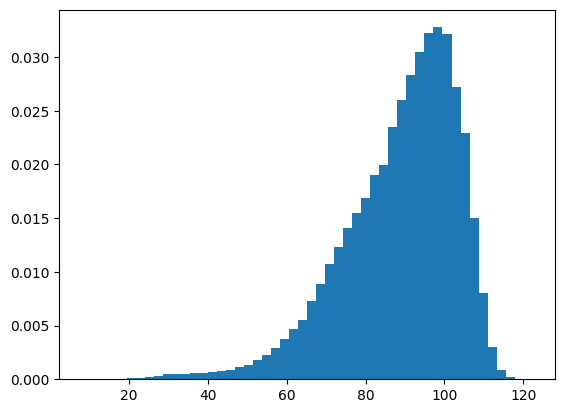

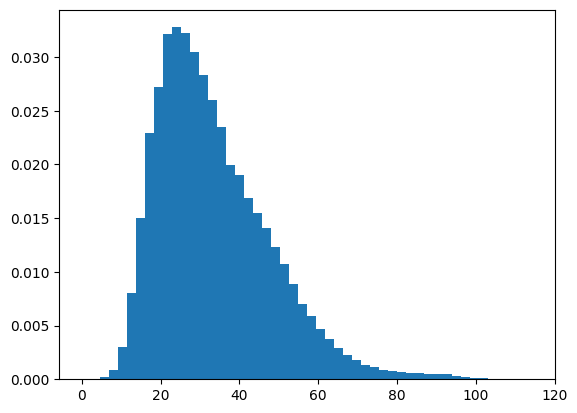

In [20]:
plt.hist(all_data.launch_speed.values, density = True, bins = 50)
plt.show()
plt.hist(all_data.launch_speed.max() - all_data.launch_speed.values, density = True, bins = 50)
plt.show()

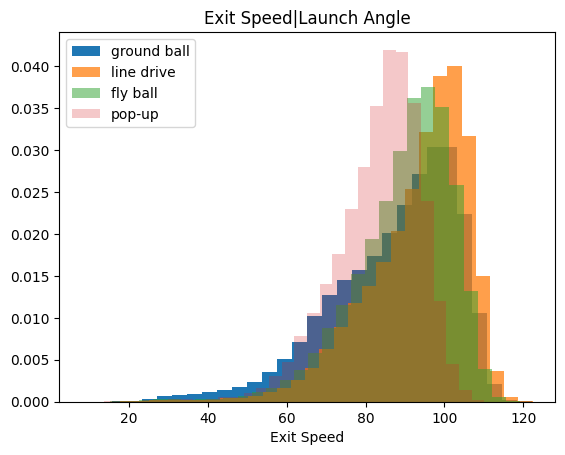

In [21]:
plt.hist(all_data.loc[all_data.la_type == 0].launch_speed.values, density = True, bins = 30, label = 'ground ball')
plt.hist(all_data.loc[all_data.la_type == 1].launch_speed.values, density = True, bins = 30, label = 'line drive', alpha = 0.75)
plt.hist(all_data.loc[all_data.la_type == 2].launch_speed.values, density = True, bins = 30, label = 'fly ball',alpha = 0.5)
plt.hist(all_data.loc[all_data.la_type == 3].launch_speed.values, density = True, bins = 30, label = 'pop-up',alpha = 0.25)
plt.legend()
plt.title('Exit Speed|Launch Angle')
plt.xlabel('Exit Speed')
plt.show()

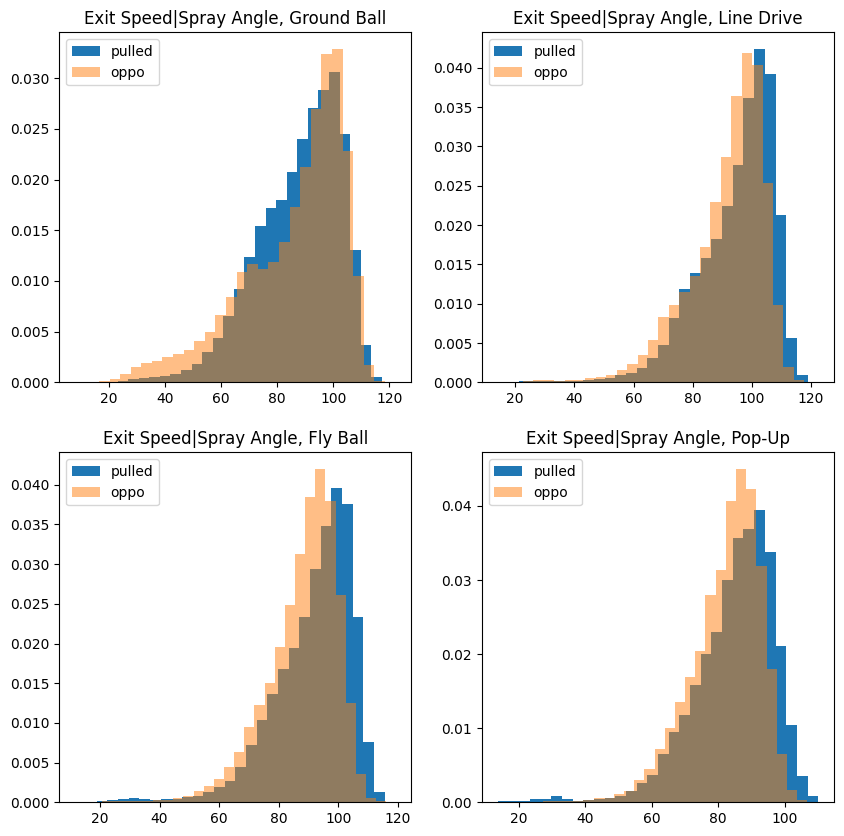

In [22]:
#see if exit speed is independent of spray angle conditioned on launch angle
plt.figure(figsize=(10,10))
gb = all_data.loc[all_data.la_type == 0]
ax1 = plt.subplot(221)
ax1.hist(gb.loc[gb.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax1.hist(gb.loc[gb.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax1.legend()
ax1.set_title('Exit Speed|Spray Angle, Ground Ball')

ld = all_data.loc[all_data.la_type == 1]
ax2 = plt.subplot(222)
ax2.hist(ld.loc[ld.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax2.hist(ld.loc[ld.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax2.legend()
ax2.set_title('Exit Speed|Spray Angle, Line Drive')

fb = all_data.loc[all_data.la_type == 2]
ax3 = plt.subplot(223)
ax3.hist(fb.loc[fb.hit_direction <= 0].launch_speed.values, density = True, bins = 30,  label = 'pulled')
ax3.hist(fb.loc[fb.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax3.legend()
ax3.set_title('Exit Speed|Spray Angle, Fly Ball')

pu = all_data.loc[all_data.la_type == 3]
ax4 = plt.subplot(224)
ax4.hist(pu.loc[pu.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax4.hist(pu.loc[pu.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax4.legend()
ax4.set_title('Exit Speed|Spray Angle, Pop-Up')
plt.show()

In [23]:
#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

all_data = all_data.merge(batter_indices, on = 'batter_id_hand')

#train test split on 2023
train = all_data.loc[all_data.game_year < 2023]
test = all_data.loc[all_data.game_year == 2023]

### Model: Gamma dists broken down by LA type

In [24]:
max_ev = all_data.launch_speed.max()+0.1
max_ev

122.5

In [25]:
#estimates for the priors
alphas = []
scales = []
hittypes = []
for b in batter_indices.batter_index.values:
    d = train.loc[train.batter_index == b]
    for ht in range(4):
        dt = d.loc[d.la_type == ht]
        if dt.shape[0] < 20:
            continue
        #use mle to get alpha and scale
        a, _, scale = gamma.fit(max_ev - dt.launch_speed.values, floc = 0)
        alphas.append(a)
        scales.append(scale)
        hittypes.append(ht)
hitter_info = pd.DataFrame({'la_type': hittypes, 'alpha': alphas, 'scale': scales})

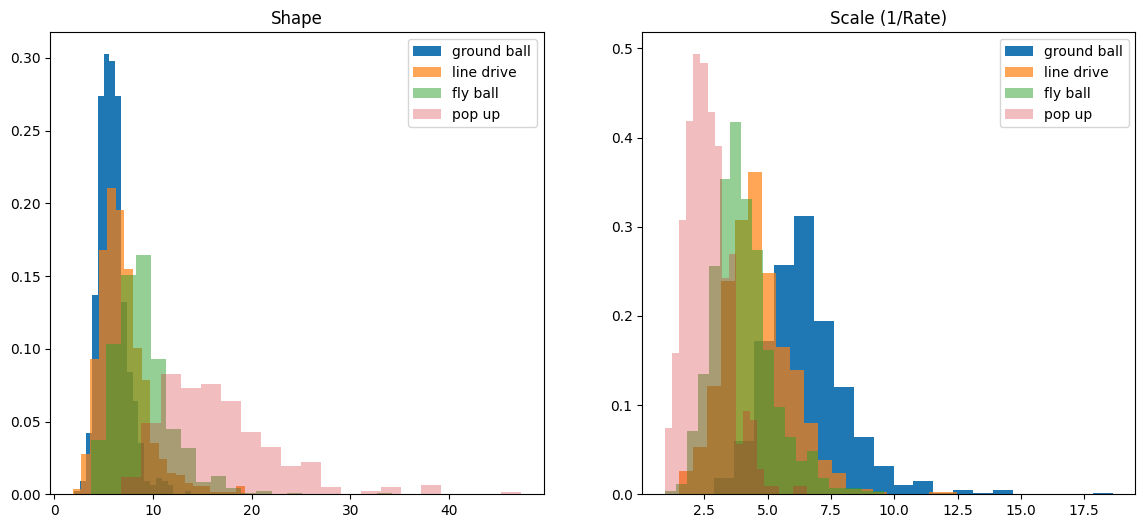

In [26]:
plt.figure(figsize = (14,6))
ax1 = plt.subplot(121)
ax1.hist(hitter_info.loc[hitter_info.la_type == 0].alpha.values, density = True, bins = 20, label = 'ground ball')
ax1.hist(hitter_info.loc[hitter_info.la_type == 1].alpha.values, density = True, bins = 20, alpha = 0.7, label = 'line drive')
ax1.hist(hitter_info.loc[hitter_info.la_type == 2].alpha.values, density = True, bins = 20, alpha = 0.5, label = 'fly ball')
ax1.hist(hitter_info.loc[hitter_info.la_type == 3].alpha.values, density = True, bins = 20, alpha = 0.3, label = 'pop up')
ax1.set_title('Shape')
ax1.legend()
ax2 = plt.subplot(122)
ax2.hist(hitter_info.loc[hitter_info.la_type == 0].scale.values, density = True, bins = 20, label = 'ground ball')
ax2.hist(hitter_info.loc[hitter_info.la_type == 1].scale.values, density = True, bins = 20, alpha = 0.7, label = 'line drive')
ax2.hist(hitter_info.loc[hitter_info.la_type == 2].scale.values, density = True, bins = 20, alpha = 0.5, label = 'fly ball')
ax2.hist(hitter_info.loc[hitter_info.la_type == 3].scale.values, density = True, bins = 20, alpha = 0.3, label = 'pop up')
ax2.set_title('Scale (1/Rate)')
ax2.legend()
plt.show()

In [27]:
alpha_means = np.array([hitter_info.loc[hitter_info.la_type == 0].alpha.mean(),hitter_info.loc[hitter_info.la_type == 1].alpha.mean(),hitter_info.loc[hitter_info.la_type == 2].alpha.mean(),hitter_info.loc[hitter_info.la_type == 3].alpha.mean()])
alpha_stds = np.array([hitter_info.loc[hitter_info.la_type == 0].alpha.std(),hitter_info.loc[hitter_info.la_type == 1].alpha.std(),hitter_info.loc[hitter_info.la_type == 2].alpha.std(),hitter_info.loc[hitter_info.la_type == 3].alpha.std()])

scale_means = np.array([hitter_info.loc[hitter_info.la_type == 0].scale.mean(),hitter_info.loc[hitter_info.la_type == 1].scale.mean(),hitter_info.loc[hitter_info.la_type == 2].scale.mean(),hitter_info.loc[hitter_info.la_type == 3].scale.mean()])
scale_stds = np.array([hitter_info.loc[hitter_info.la_type == 0].scale.std(),hitter_info.loc[hitter_info.la_type == 1].scale.std(),hitter_info.loc[hitter_info.la_type == 2].scale.std(),hitter_info.loc[hitter_info.la_type == 3].scale.std()])

In [28]:
alpha_means, alpha_stds

(array([ 5.91606828,  6.99321172,  9.0350978 , 16.6693239 ]),
 array([1.43917298, 2.41900985, 3.02156776, 5.84198264]))

In [29]:
scale_means, scale_stds

(array([6.53119706, 4.62405845, 4.02362993, 2.64166145]),
 array([1.65113373, 1.3329676 , 1.18184951, 0.8492376 ]))

In [ ]:
#fit the model
n_batters = len(train.batter_index.unique())
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'hit_type': [0,1,2,3]} # hit type corresponds to the launch angle type

with pm.Model(coords = coords) as mod1:
    #the alpha values are batter specific and they have gamma priors
    batteralphas = pm.Gamma('batteralphas', mu = alpha_means, sigma = alpha_stds, dims = ('batter', 'hit_type'))

    #the scale values are batter specific and have gamma priors
    batterscales = pm.Gamma('batterscales', mu = scale_means, sigma = scale_stds, dims = ('batter', 'hit_type'))

    #likelihoods are gamma distributed, one for each launch angle type
    ht = pm.Data('ht', train.la_type.values, dims = 'observation')
    b = pm.Data('b', train.batter_index.values, dims = 'observation')
    x = pm.Data('x', max_ev-train.launch_speed.values, dims = 'observation')
    likelihood = pm.Gamma('likelihood', alpha = batteralphas[b, ht], beta = 1/batterscales[b,ht],  observed = x, dims = 'observation')

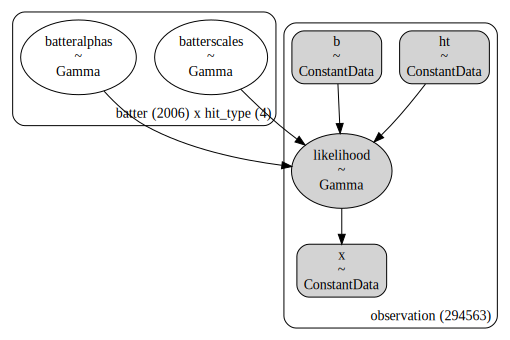

In [ ]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    trace = pmjax.sample_numpyro_nuts(2000,chains=1, random_seed=42)

Compiling...
Compilation time =  0:00:33.428648
Sampling...


sample: 100%|██████████| 3000/3000 [12:22<00:00,  4.04it/s, 127 steps of size 3.95e-02. acc. prob=0.87]


Sampling time =  0:12:28.369938
Transforming variables...
Transformation time =  0:00:00.416339


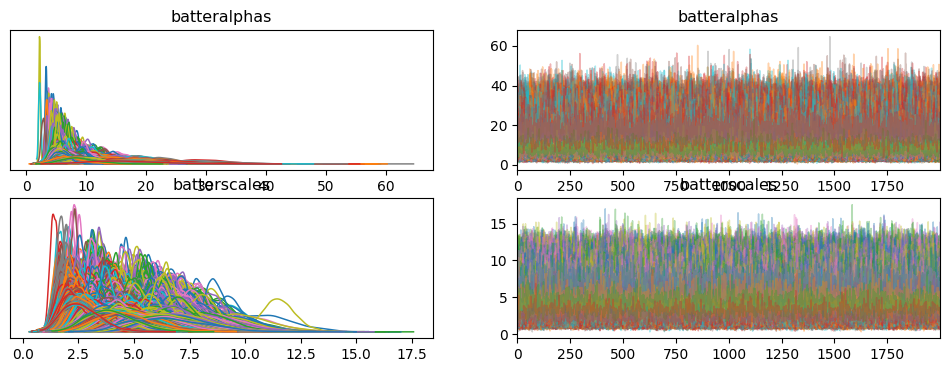

In [ ]:
az.plot_trace(trace)
plt.show()

In [ ]:
balphas = trace.posterior.batteralphas.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu']] = balphas

bscales = trace.posterior.batterscales.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']] = bscales
#save the results so that I can use them for testing the neural net version
batter_indices.to_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/exit_speed/ev_dists_sloan_version_testing.csv', index=False)

In [ ]:
batter_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/exit_speed/ev_dists_sloan_version_testing.csv')

In [ ]:
train = train.merge(batter_indices[['batter_index', 'batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu', 'batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']], on = 'batter_index')
test =test.merge(batter_indices[['batter_index', 'batter_a_gb', 'batter_a_ld', 'batter_a_fb', 'batter_a_pu', 'batter_s_gb', 'batter_s_ld', 'batter_s_fb', 'batter_s_pu']], on = 'batter_index')

In [ ]:
train['ev2'] = max_ev - train.launch_speed.values
test['ev2'] = max_ev - test.launch_speed.values

In [ ]:
train['log_like'] = train.is_gb.values * gamma(a = train.batter_a_gb.values, scale = train.batter_s_gb.values).logpdf(train.ev2.values) + train.is_fb.values * gamma(a = train.batter_a_fb.values, scale = train.batter_s_fb.values).logpdf(train.ev2.values) + train.is_ld.values * gamma(a = train.batter_a_ld.values, scale = train.batter_s_ld.values).logpdf(train.ev2.values) + train.is_pu.values * gamma(a = train.batter_a_pu.values, scale = train.batter_s_pu.values).logpdf(train.ev2.values)

test['log_like'] = test.is_gb.values * gamma(a = test.batter_a_gb.values, scale = test.batter_s_gb.values).logpdf(test.ev2.values) + test.is_fb.values * gamma(a = test.batter_a_fb.values, scale = test.batter_s_fb.values).logpdf(test.ev2.values) + test.is_ld.values * gamma(a = test.batter_a_ld.values, scale = test.batter_s_ld.values).logpdf(test.ev2.values) + test.is_pu.values * gamma(a = test.batter_a_pu.values, scale = test.batter_s_pu.values).logpdf(test.ev2.values)
train.log_like.mean(), test.log_like.mean()

(-3.9155222745287115, -3.944360144867917)

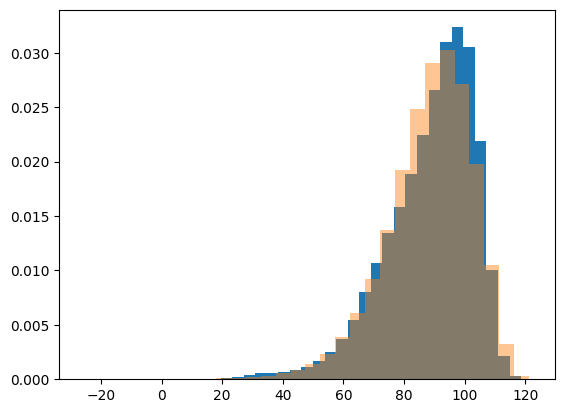

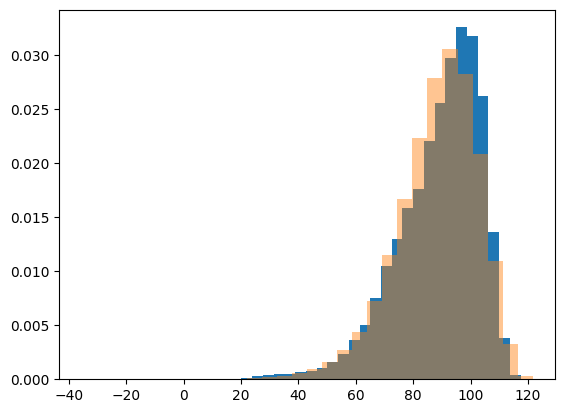

In [ ]:
#draw samples
train['a'] = train.is_gb.values * train.batter_a_gb.values + train.is_ld.values * train.batter_a_ld.values + train.is_fb.values * train.batter_a_fb.values + train.is_pu.values * train.batter_a_pu.values
test['a'] = test.is_gb.values * test.batter_a_gb.values + test.is_ld.values * test.batter_a_ld.values + test.is_fb.values * test.batter_a_fb.values + test.is_pu.values * test.batter_a_pu.values
train['s'] = train.is_gb.values * train.batter_s_gb.values + train.is_ld.values * train.batter_s_ld.values + train.is_fb.values * train.batter_s_fb.values + train.is_pu.values * train.batter_s_pu.values
test['s'] = test.is_gb.values * test.batter_s_gb.values + test.is_ld.values * test.batter_s_ld.values + test.is_fb.values * test.batter_s_fb.values + test.is_pu.values * test.batter_s_pu.values
samp = gamma(a = train.a.values, scale = train.s.values).rvs()
plt.hist(max_ev - train.ev2.values, density = True, bins = 30)
plt.hist(max_ev - samp, density = True, bins = 30, alpha = 0.45)
plt.show()

samp = gamma(a = test.a.values, scale = test.s.values).rvs()
plt.hist(max_ev - test.ev2.values, density = True, bins = 30)
plt.hist(max_ev - samp, density = True, bins = 30, alpha = 0.45)
plt.show()

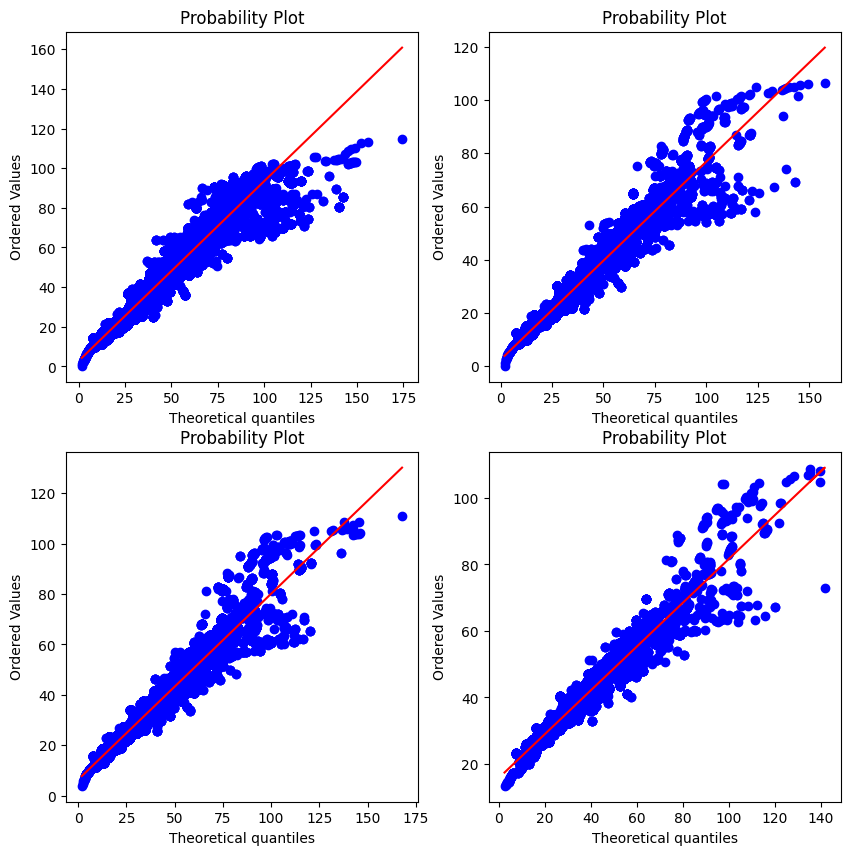

In [ ]:
## QQ Plot
gbte = train.loc[train.is_gb == 1]
ldte = train.loc[train.is_ld == 1]
fbte = train.loc[train.is_fb == 1]
pute = train.loc[train.is_pu == 1]
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
probplot(gbte.ev2.values, dist = gamma(a = gbte.batter_a_gb.values, scale = gbte.batter_s_gb.values), plot = ax1)
probplot(ldte.ev2.values, dist = gamma(a = ldte.batter_a_gb.values, scale = ldte.batter_s_gb.values), plot = ax2)
probplot(fbte.ev2.values, dist = gamma(a = fbte.batter_a_gb.values, scale = fbte.batter_s_gb.values), plot = ax3)
probplot(pute.ev2.values, dist = gamma(a = pute.batter_a_gb.values, scale = pute.batter_s_gb.values), plot = ax4)
plt.show()

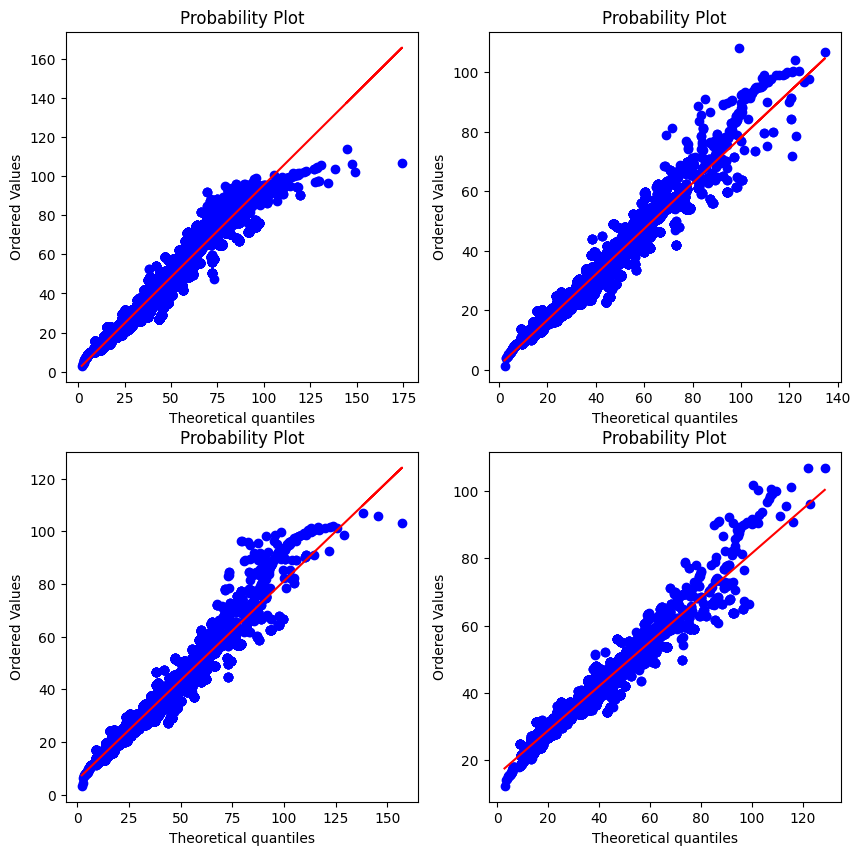

In [ ]:
gbte = test.loc[test.is_gb == 1]
ldte = test.loc[test.is_ld == 1]
fbte = test.loc[test.is_fb == 1]
pute = test.loc[test.is_pu == 1]
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
probplot(gbte.ev2.values, dist = gamma(a = gbte.batter_a_gb.values, scale = gbte.batter_s_gb.values), plot = ax1)
probplot(ldte.ev2.values, dist = gamma(a = ldte.batter_a_gb.values, scale = ldte.batter_s_gb.values), plot = ax2)
probplot(fbte.ev2.values, dist = gamma(a = fbte.batter_a_gb.values, scale = fbte.batter_s_gb.values), plot = ax3)
probplot(pute.ev2.values, dist = gamma(a = pute.batter_a_gb.values, scale = pute.batter_s_gb.values), plot = ax4)
plt.show()

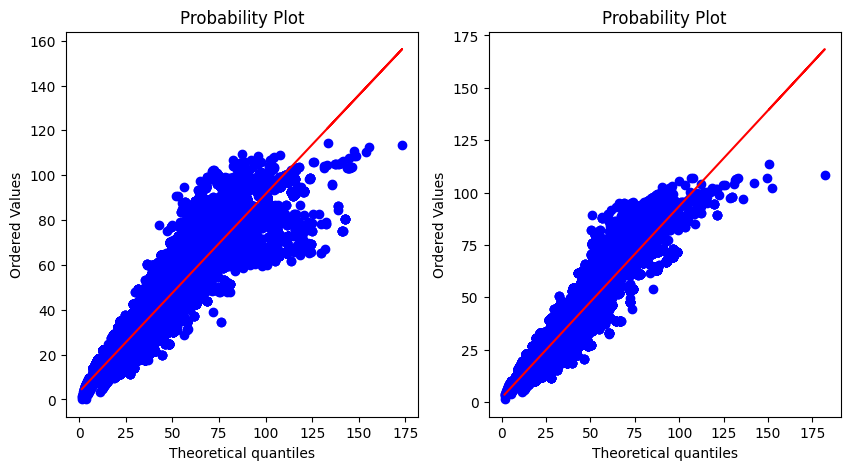

In [ ]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
probplot(train.ev2.values, dist = gamma(a = train.a.values, scale = train.s.values), plot = ax1)
probplot(test.ev2.values, dist = gamma(a = test.a.values, scale = test.s.values), plot = ax2)
plt.show()

In [ ]:
def custom_qq_plot(dataframe):
    for b in batter_indices.batter_index.values:
        for ht in [0,1,2,3]:
            d = dataframe.loc[(dataframe.batter_index == b) & (dataframe.la_type == ht)]
            if d.shape[0]==0:
                continue
            nts = [np.mean(i >= d.ev2.values) for i in d.ev2.values]
            ntiles = np.array(nts)
            #calculate the quantiles for each of those points given the true posterior distribution
            if ht == 0:
                actual_quantiles = gamma(a = d.batter_a_gb.values[0], scale = d.batter_s_gb.values[0]).ppf(ntiles)

            elif ht == 1:
                actual_quantiles = gamma(a = d.batter_a_ld.values[0], scale = d.batter_s_ld.values[0]).ppf(ntiles)

            elif ht == 2:
                actual_quantiles = gamma(a = d.batter_a_fb.values[0], scale = d.batter_s_fb.values[0]).ppf(ntiles)
            else:
                actual_quantiles = gamma(a = d.batter_a_pu.values[0], scale = d.batter_s_pu.values[0]).ppf(ntiles)

            plt.plot(actual_quantiles, d.ev2.values, 'k.')
    plt.plot([0,125],[0,125], 'r-')
    plt.xlabel('Theoretical Quantile')
    plt.ylabel('Empirical Quantile')
    plt.title('QQ plot')
    plt.show()

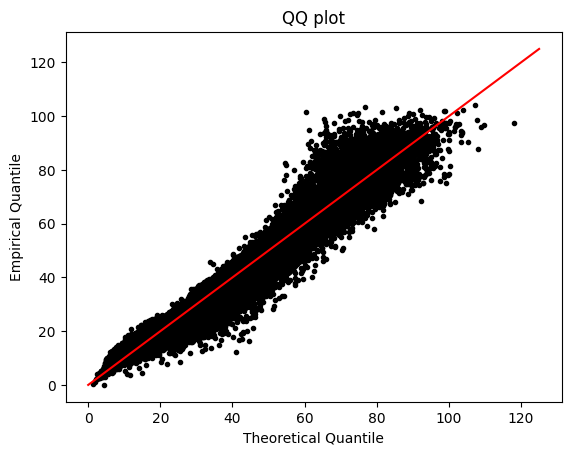

In [ ]:
custom_qq_plot(train)

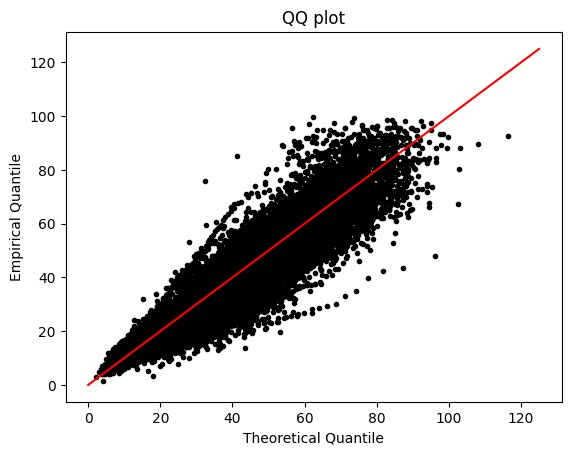

In [ ]:
custom_qq_plot(test)

In [ ]:
# PP Plot
def pp_plot(dataframe):
    dataframe = dataframe.sort_values(['batter_index', 'la_type'])
    #get the ntiles for each point in the data
    ntiles = []
    for b in batter_indices.batter_index.values:
        for ht in range(4):
            d = dataframe.loc[(dataframe.batter_index == b) & (dataframe.la_type == ht)]
            if d.shape[0] == 0:
                continue
            nts = np.array([np.mean(i >= d.ev2.values) for i in d.ev2.values])
            if ht == 1:
                actual_ntiles = gamma(a = d.batter_a_ld.values[0], scale = d.batter_s_ld.values[0]).cdf(d.ev2.values)
            elif ht == 0:
                actual_ntiles = gamma(a = d.batter_a_gb.values[0], scale = d.batter_s_gb.values[0]).cdf(d.ev2.values)
            elif ht == 2:
                actual_ntiles = gamma(a = d.batter_a_fb.values[0], scale = d.batter_s_fb.values[0]).cdf(d.ev2.values)
            else:
                actual_ntiles = gamma(a = d.batter_a_pu.values[0], scale = d.batter_s_pu.values[0]).cdf(d.ev2.values)
            plt.plot(nts,actual_ntiles, 'k.')
    plt.plot([0,1],[0,1], 'r-')
    plt.xlabel('empirical cdf')
    plt.ylabel('theoretical cdf')
    plt.title('PP Plot')
    plt.show()

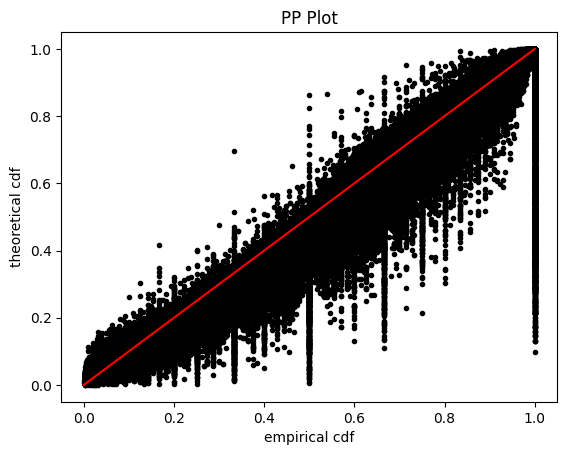

In [ ]:
pp_plot(train)

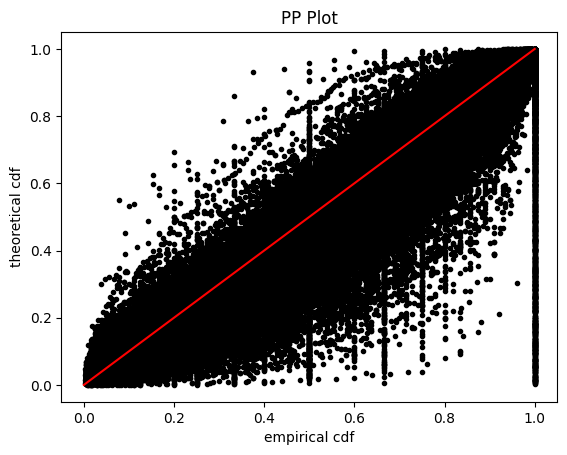

In [ ]:
pp_plot(test)